# Influence function example for Cifar-10, ResNet
### References
***
- Darkon: <http://darkon.io>
- Resnet code: <https://github.com/wenxinxu/resnet-in-tensorflow>
- More examples: <https://github.com/darkonhub/darkon-examples>

### Prepare
***
```
# cpu
pip install -r requirements.txt

# gpu
pip install -r requirements.txt
pip install tensorflow-gpu
```

### Import packages

In [1]:
# resnet: implemented by wenxinxu
from cifar10_train import Train
from cifar10_input import *

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import darkon

# to enable specific GPU
%set_env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

# cifar-10 classes
_classes = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

env: CUDA_VISIBLE_DEVICES=0


### Implement dataset feeder

In [2]:
class MyFeeder(darkon.InfluenceFeeder):
    def __init__(self):
        # load train data
        data, label = prepare_train_data(padding_size=0)
        self.train_origin_data = data / 256.
        self.train_label = label
        self.train_data = whitening_image(data)

        # load test data
        data, label = read_validation_data_wo_whitening()
        self.test_origin_data = data / 256.
        self.test_label = label
        self.test_data = whitening_image(data)
       
        self.train_batch_offset = 0

    def test_indices(self, indices):
        return self.test_data[indices], self.test_label[indices]

    def train_batch(self, batch_size):
        # calculate offset
        start = self.train_batch_offset
        end = start + batch_size
        self.train_batch_offset += batch_size

        return self.train_data[start:end, ...], self.train_label[start:end, ...]

    def train_one(self, idx):
        # no need in this example
        pass

    def reset(self):
        self.train_batch_offset = 0

feeder = MyFeeder()

Reading images from cifar10_data/cifar-10-batches-py/data_batch_1
Reading images from cifar10_data/cifar-10-batches-py/data_batch_2
Reading images from cifar10_data/cifar-10-batches-py/data_batch_3
Reading images from cifar10_data/cifar-10-batches-py/data_batch_4
Reading images from cifar10_data/cifar-10-batches-py/data_batch_5
Reading images from cifar10_data/cifar-10-batches-py/test_batch


### Restore pre-trained model

In [3]:
# tf model checkpoint
check_point = 'pre-trained/model.ckpt-79999'

net = Train()
net.build_train_validation_graph()

saver = tf.train.Saver(tf.global_variables())
sess = tf.InteractiveSession()
saver.restore(sess, check_point)

INFO:tensorflow:Restoring parameters from pre-trained/model.ckpt-79999


### Initialize influence module

In [4]:
inspector = darkon.Influence(
    workspace='./influence-workspace',
    feeder=feeder,
    loss_op_train=net.full_loss,
    loss_op_test=net.loss_op,
    x_placeholder=net.image_placeholder,
    y_placeholder=net.label_placeholder)

### Upweight influence options

horse


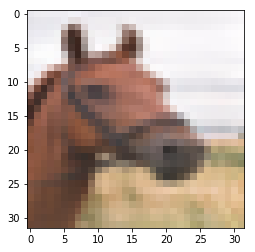

In [13]:
influence_target = 99

# display
print(_classes[int(feeder.test_label[influence_target])])
plt.imshow(feeder.test_origin_data[influence_target])

test_indices = [influence_target]
testset_batch_size = 100

train_batch_size = 100
train_iterations = 500

# train_batch_size = 100
# train_iterations = 50

approx_params = {
    'scale': 200,
    'num_repeats': 5,
    'recursion_depth': 100,
    'recursion_batch_size': 100
}

### Run upweight influence function

In [14]:
scores = inspector.upweighting_influence_batch(
    sess,
    test_indices,
    testset_batch_size,
    approx_params,
    train_batch_size,
    train_iterations)


2017-11-22 16:12:12,272 darkon INFO: Norm of test gradient: 11.0568
2017-11-22 16:12:13,735 darkon INFO: Recursion at depth 0: norm is 22.00053596
2017-11-22 16:12:14,735 darkon INFO: Recursion at depth 10: norm is 125.56706238
2017-11-22 16:12:15,717 darkon INFO: Recursion at depth 20: norm is 219.14535522
2017-11-22 16:12:16,695 darkon INFO: Recursion at depth 30: norm is 303.55877686
2017-11-22 16:12:17,676 darkon INFO: Recursion at depth 40: norm is 379.90979004
2017-11-22 16:12:18,654 darkon INFO: Recursion at depth 50: norm is 449.01867676
2017-11-22 16:12:19,637 darkon INFO: Recursion at depth 60: norm is 511.16824341
2017-11-22 16:12:20,616 darkon INFO: Recursion at depth 70: norm is 567.64385986
2017-11-22 16:12:21,599 darkon INFO: Recursion at depth 80: norm is 618.42864990
2017-11-22 16:12:22,586 darkon INFO: Recursion at depth 90: norm is 664.26245117
2017-11-22 16:12:23,480 darkon INFO: Recursion at depth 99: norm is 701.82507324
2017-11-22 16:12:23,581 darkon INFO: Recurs

### Check helpful/unhelpful indices and scores

In [17]:
sorted_indices = np.argsort(scores)
unhelpful = sorted_indices[:10]
helpful = sorted_indices[-10:][::-1]

print('\nUnhelpful:')
for idx in unhelpful:
    print('[{}] {}'.format(idx, scores[idx]))
    
print('\nHelpful:')
for idx in helpful:
    print('[{}] {}'.format(idx, scores[idx]))




Unhelpful:
[18478] -9.36769841439e-05
[42222] -8.46888645517e-05
[2246] -8.23997404303e-05
[39682] -8.15817638342e-05
[7229] -8.08643413551e-05
[7160] -8.05636396462e-05
[28758] -7.92508989566e-05
[45043] -7.84011747274e-05
[29760] -7.79298847103e-05
[11034] -7.69198078647e-05

Helpful:
[14989] 0.000366906680877
[5447] 0.000359578779517
[10358] 0.000346645999667
[42546] 0.000343599054643
[46517] 0.000342480262225
[6189] 0.000340014827064
[27038] 0.000336939557462
[11595] 0.000335732842067
[26193] 0.000332723756033
[7682] 0.000331258133185


### Display helpful train data

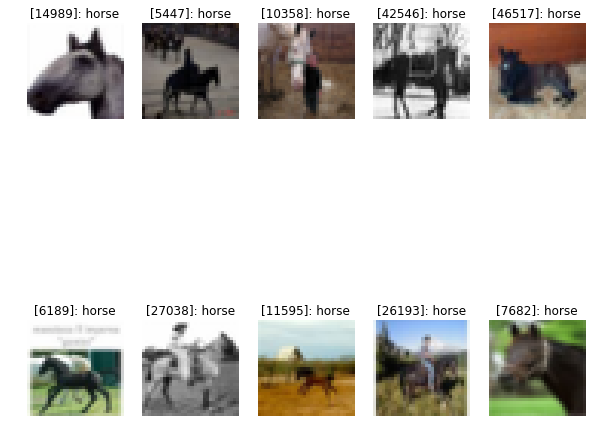

In [19]:
fig, axes1 = plt.subplots(2, 5, figsize=(10, 10))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = helpful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = _classes[int(feeder.train_label[idx])]
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

### Display unhelpful train data

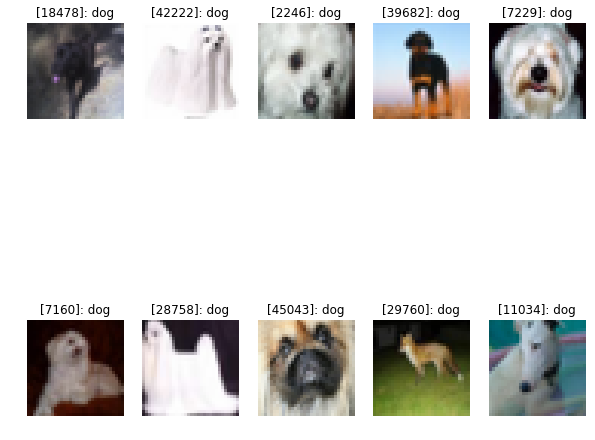

In [21]:
fig, axes1 = plt.subplots(2, 5, figsize=(10, 10))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = unhelpful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = _classes[int(feeder.train_label[idx])]
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

***
>***[Copyright 2017 Neosapience, Inc.](http://www.neosapience.com)***
>
>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

>    http://www.apache.org/licenses/LICENSE-2.0

>Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

***